In [5]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pygplates
import pygmt

from gprm import ReconstructionModel
from gprm.datasets import Rocks, Reconstructions, Paleogeography, Geology
from gprm.utils.raster import to_anchor_plate

import sys
#sys.path.append('/Users/simon/OneDrive/Andes_works//python/')
sys.path.append('../python/')
import joyful_geochemistry as joy
import joyful_mapping as joymap

import collections

%matplotlib inline
%load_ext autoreload
%autoreload 2


############## Settings for Scotese Paleomap
PaleomapDictionary = {}
PaleomapDictionary['name'] = 'Paleomap'
PaleomapDictionary['reconstruction_model'] = Reconstructions.fetch_Scotese()
PaleomapDictionary['raster_sequence'] = Paleogeography.fetch_Paleomap()
PaleomapDictionary['maximum_time'] = 350.
PaleomapDictionary['time_bin_size'] = 10.
PaleomapDictionary['anchor_plate_id'] = 201
PaleomapDictionary['raster_anchor_plate_id'] = 0

#Paleomap = Reconstructions.fetch_Scotese()
#PaleoDEM = Paleogeography.fetch_Paleomap()


############## Settings for Boschman model
boschman_rotation_model = ReconstructionModel('')
boschman_rotation_model.add_rotation_model('/Users/simon/GIT/bx/andes//boschman/reconstruction_model/boschman_reverse_engineered_rotations.rot')
boschman_rotation_model.add_static_polygons('/Users/simon/GIT/bx/andes//boschman/reconstruction_model/reconstructed_0.00Ma.shp')

raster_dict = {}
for reconstruction_time in np.arange(0,81,1):
    raster_dict[reconstruction_time] = '/Users/simon/GIT/bx/andes//boschman/grids/boschman_DEM_{:0.0f}Ma.nc'.format(reconstruction_time)
boschman_rasters = collections.OrderedDict(sorted(raster_dict.items()))


BoschmanDictionary = {}
BoschmanDictionary['name'] = 'Boschman'
BoschmanDictionary['reconstruction_model'] = boschman_rotation_model
BoschmanDictionary['raster_sequence'] = boschman_rasters
BoschmanDictionary['maximum_time'] = 80.
BoschmanDictionary['time_bin_size'] = 5.
BoschmanDictionary['anchor_plate_id'] = 201
BoschmanDictionary['raster_anchor_plate_id'] = 201


########## Geochemistry Inputs
df = joy.geochem_from_csv('../datafiles/geochem_merge_20221026.csv')

model_dir = '../luffi/REM_surfaces_csv/'
gc_interpolator_dict = joy.make_gc_interpolator_dict(model_dir)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ERROR 1: PROJ: proj_identify: Cannot find proj.db
ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db
ERROR 1: PROJ: proj_identify: Cannot find proj.db
ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db
ERROR 1: PROJ: proj_identify: Cannot find proj.db
ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db


<Axes: >

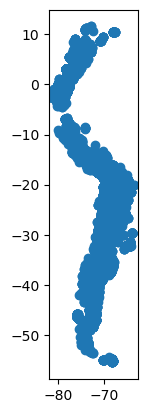

In [6]:
df = joymap.select_orogens(df,gdf=None, 
                           orogen_names='Cordilleran', 
                           continent_names='South America',
                           region=[-100, -50, -60, 20])


pilger_volcanics = joymap.load_pilger_volcanics('/Users/simon/OneDrive/Andes_works//datafiles/2022-2-NGG0Q7_Pilger_Andean-Igneous-Radiometric-Dates.xlsx')

#df.plot()

In [8]:
###########################################
MODEL = PaleomapDictionary
#MODEL = BoschmanDictionary
###########################################

region = [-85, -55, -58, 12]
#region = [-76, -66, -25, -12]
projection="M10c"
perspective = [240, 35]

###########################################



time_bin_size = MODEL['time_bin_size']
space_bin_size = 1.

#calibration = 'Hu'
#mohometer_selection = ['la_yb_elevation']

calibration = 'luffi'
mohometer_selection = 50

anchor_plate_id = MODEL['anchor_plate_id']
raster_anchor_plate_id = MODEL['raster_anchor_plate_id']

reconstruction_model = MODEL['reconstruction_model']
raster_sequence = MODEL['raster_sequence']



if isinstance(mohometer_selection, list):
    mohometer_description_string = '|'.join(mohometer_selection)
else:
    mohometer_description_string = str(mohometer_selection)

    
    
for reconstruction_time in np.arange(0,MODEL['maximum_time'],time_bin_size):
    
    fig = pygmt.Figure()

    binned_elevations = joymap.timeslice_plot(df, reconstruction_time,
                                              time_bin_size, space_bin_size, 
                                              fig, raster_sequence, reconstruction_model, 
                                              anchor_plate_id=anchor_plate_id, raster_anchor_plate_id=raster_anchor_plate_id,
                                              gc_interpolator_dict=gc_interpolator_dict, 
                                              calibration=calibration, mohometer_selection=mohometer_selection,
                                              region=region, projection=projection, perspective=perspective, 
                                              volcanics=pilger_volcanics, return_type='binned_elevations')
    
    joymap.add_labels(fig, reconstruction_time, time_bin_size, add_colorbar=True)
    
    fig.savefig('../images/sequence_{:s}/elevations_plus_volcanism_{:s}_{:s}_{:0.0f}Ma.png'.format(MODEL['name'],
                                                                                                   calibration,
                                                                                                   mohometer_description_string, 
                                                                                                   reconstruction_time))
    #fig.show(width=1000)
    
    fig = pygmt.Figure()

    binned_residuals = joymap.timeslice_plot(df, reconstruction_time,
                                             time_bin_size, space_bin_size, 
                                             fig, raster_sequence, reconstruction_model, 
                                             anchor_plate_id=anchor_plate_id, raster_anchor_plate_id=raster_anchor_plate_id,
                                             gc_interpolator_dict=gc_interpolator_dict, 
                                             calibration=calibration, mohometer_selection=mohometer_selection,
                                             region=region, projection=projection, perspective=perspective, 
                                             volcanics=None, residuals=True, return_type='binned_residuals')
    
    joymap.add_labels(fig, reconstruction_time, time_bin_size, add_colorbar=True)
    
    fig.savefig('../images/sequence_{:s}/elevation_residuals_{:s}_{:s}_{:0.0f}Ma.png'.format(MODEL['name'],
                                                                                   calibration,
                                                                                   mohometer_description_string, 
                                                                                   reconstruction_time))
    #fig.show(width=1000)
    
    joymap.residuals_crossplot(binned_elevations, binned_residuals,
                               fname='../images/sequence_{:s}/crossplot_{:s}_{:s}_{:0.1f}Ma.png'.format(MODEL['name'],
                                                                                                        calibration,
                                                                                                        mohometer_description_string, 
                                                                                                        reconstruction_time))
    #break
    


Number of samples after basic filtering 19564
Final number of samples passed = 19564
TODO implement min/max elevation cutoffs
0.0
Number of samples after basic filtering 19564
Final number of samples passed = 19564
TODO implement min/max elevation cutoffs
Number of samples after basic filtering 587
Final number of samples passed = 587
TODO implement min/max elevation cutoffs
10.0
Number of samples after basic filtering 587
Final number of samples passed = 587
TODO implement min/max elevation cutoffs
Number of samples after basic filtering 231
Final number of samples passed = 231
TODO implement min/max elevation cutoffs
20.0
Number of samples after basic filtering 231
Final number of samples passed = 231
TODO implement min/max elevation cutoffs
Number of samples after basic filtering 409
Final number of samples passed = 409
TODO implement min/max elevation cutoffs
30.0
Number of samples after basic filtering 409
Final number of samples passed = 409
TODO implement min/max elevation cutof

In [4]:
    
time_bin_size = 20
space_bin_size = 1.

fig = pygmt.Figure()

for reconstruction_time in np.arange(10,120,time_bin_size): 
    joymap.timeslice_plot(df, reconstruction_time,
                          time_bin_size, space_bin_size, gc_interpolator_dict,
                          fig, raster_sequence, reconstruction_model)
    
    fig.shift_origin(yshift='-8c')

fig.shift_origin(yshift='48c', xshift='32c')
for reconstruction_time in np.arange(130,240,time_bin_size):
    joymap.timeslice_plot(df, reconstruction_time,
                          time_bin_size, space_bin_size, gc_interpolator_dict,
                          fig, raster_sequence, reconstruction_model)
    fig.shift_origin(yshift='-8c')

fig.shift_origin(yshift='48c', xshift='32c') 
for reconstruction_time in np.arange(250,360,time_bin_size):
    joymap.timeslice_plot(df, reconstruction_time,
                          time_bin_size, space_bin_size, gc_interpolator_dict,
                          fig, raster_sequence, reconstruction_model)
    fig.shift_origin(yshift='-8c')

fig.shift_origin(yshift='4c', xshift='-23c')
with pygmt.config(FONT_ANNOT_PRIMARY='16p', FONT_LABEL='24p'):
    fig.colorbar(position='JBC+jBC+o0c+w32c/1.6c+h', frame=['x+lElevation [m]'])
    
fig.savefig('../images/elevation_vs_paleomap_perspective_Luffi.pdf')
fig.show(width=1000)


TypeError: 'Figure' object is not subscriptable